<a href="https://colab.research.google.com/github/ROHIT-ONGIT/AI-powered-predictive-maintenance-system-using-machine-learning/blob/main/Anamoly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing all important libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import seaborn as sns
from pickle import load
from pickle import dump

In [ ]:
def print_scores(y, y_pred, model):
    print(
        'Accuracy score: {:.04%}, Precision: {:.04%}, Recall: {:.04%}, F1 score: {:.04%} '.format(
            accuracy_score(y, y_pred),
            precision_score(y, y_pred, pos_label=1),
            recall_score(y, y_pred, pos_label=1),
            f1_score(y, y_pred, pos_label=1)
        ), model
    )

data visualization

In [ ]:
# Importing the dataset
normal = pd.read_csv('NB.csv')
normal['Fault'] = 1
print('Size of normal data: ',normal.shape)

abnormal = pd.read_csv('IR - 7.csv')
abnormal['Fault'] = -1
print('Size of abnormal data: ',abnormal.shape)

Size of normal data:  (121155, 3)
Size of abnormal data:  (121155, 3)


In [ ]:
normal.head(10)

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
5,0.005215,0.018696,1
6,0.030249,-0.038625,1
7,0.007510,-0.054240,1
8,-0.016481,-0.043351,1
9,-0.041932,-0.045200,1


In [ ]:
abnormal.head(10)

,DE,FE,Fault
0,-0.093238,-0.029175,-1
1,0.187288,-0.186347,-1
2,0.217663,-0.341260,-1
3,0.070172,-0.160871,-1
4,0.100385,0.179978,-1
5,0.156587,0.302840,-1
6,-0.011208,0.335096,-1
7,-0.132060,0.107658,-1
8,-0.127512,-0.028147,-1
9,-0.157887,0.160665,-1


joinning  normal and abnormal data and reset index

In [ ]:

dataset = pd.concat([normal, abnormal])
dataset = dataset.reset_index(drop=True)
dataset

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
...,...,...,...
242305,0.135958,-0.047255,-1
242306,-0.083167,-0.070882,-1
242307,0.391469,-0.181005,-1
242308,0.185501,0.136011,-1


In [ ]:
normal = dataset[dataset.Fault == 1]
abnormal = dataset[dataset.Fault == -1]

Data Screenig (Checking for null (missing) values in a dataset)

In [ ]:

features = ['DE', 'FE', 'Fault']
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null))


N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))


N = dataset.shape[0]
print('Size of cleaned dataset: ', N)

The dataset contains 0 null values
The dataset contains 6941 duplicates
Size of cleaned dataset:  235369


Statical Information

In [ ]:
dataset.describe()

,DE,FE,Fault
count,235369.000000,235369.000000,235369.000000
mean,0.007916,0.033552,-0.025904
std,0.219440,0.173038,0.999667
min,-1.425531,-0.895782,-1.000000
25%,-0.068060,-0.043762,-1.000000
50%,0.010848,0.031640,-1.000000
75%,0.082194,0.109918,1.000000
max,1.639620,0.957213,1.000000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235369 entries, 0 to 235368
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DE      235369 non-null  float64
 1   FE      235369 non-null  float64
 2   Fault   235369 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 5.4 MB


In [ ]:
import os

# Create the 'Statistics' directory if it doesn't exist
if not os.path.exists('Statistics'):
    os.makedirs('Statistics')

dataset.describe().to_csv(r'Statistics/anomaly-detection-bearing-statistics.csv', index = True)

# Exploratory Data Analysis

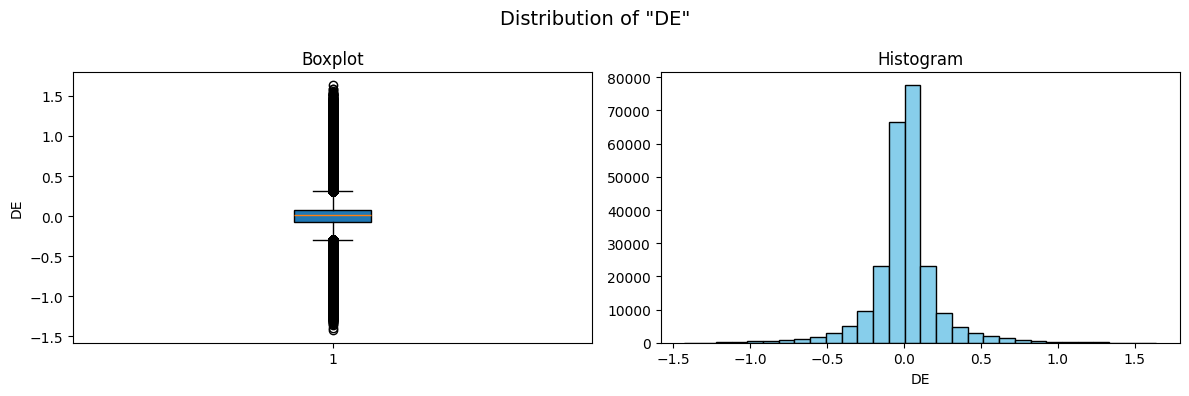

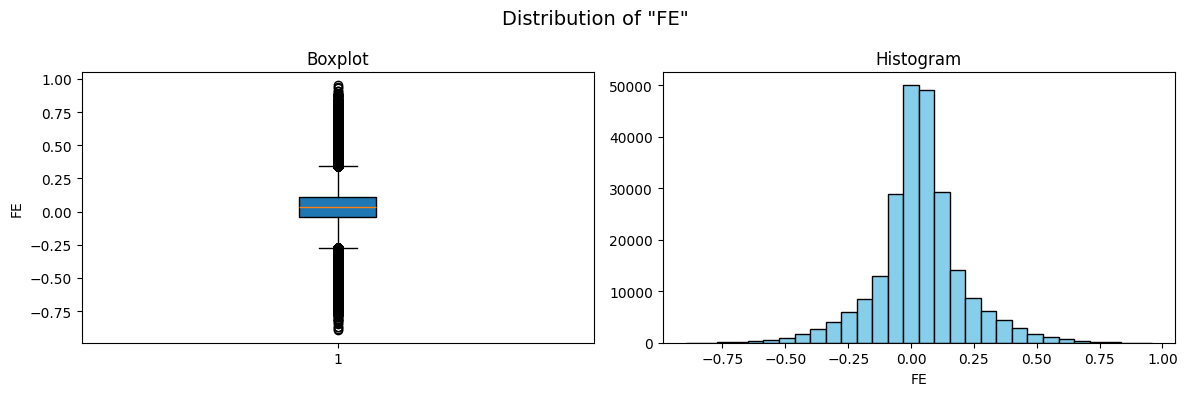

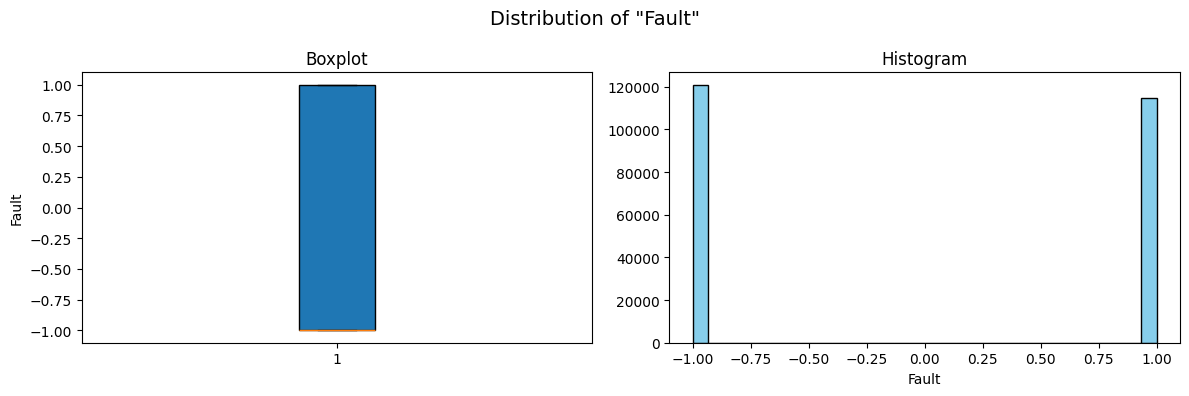

In [ ]:
for column in dataset.columns:
    data = dataset[column].dropna()  # Avoid plotting NaNs

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Distribution of "{column}"', fontsize=14)

    # Histogram
    ax2.hist(data, bins=30, color='skyblue', edgecolor='black')
    ax2.set_title("Histogram")
    ax2.set_xlabel(column)

    # Boxplot
    ax1.boxplot(data, patch_artist=True)
    ax1.set_title("Boxplot")
    ax1.set_ylabel(column)


    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_feature(feature_series, feature_label):
    indices = list(range(len(feature_series)))
    values = feature_series

    plt.figure(figsize=(16, 5))
    plt.plot(indices, values, color='teal', linewidth=1.5, linestyle='-')
    plt.title(f"{feature_label} Trend Over Time", fontsize=14)
    plt.xlabel('Data Point Index', fontsize=12)
    plt.ylabel(f"{feature_label}", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

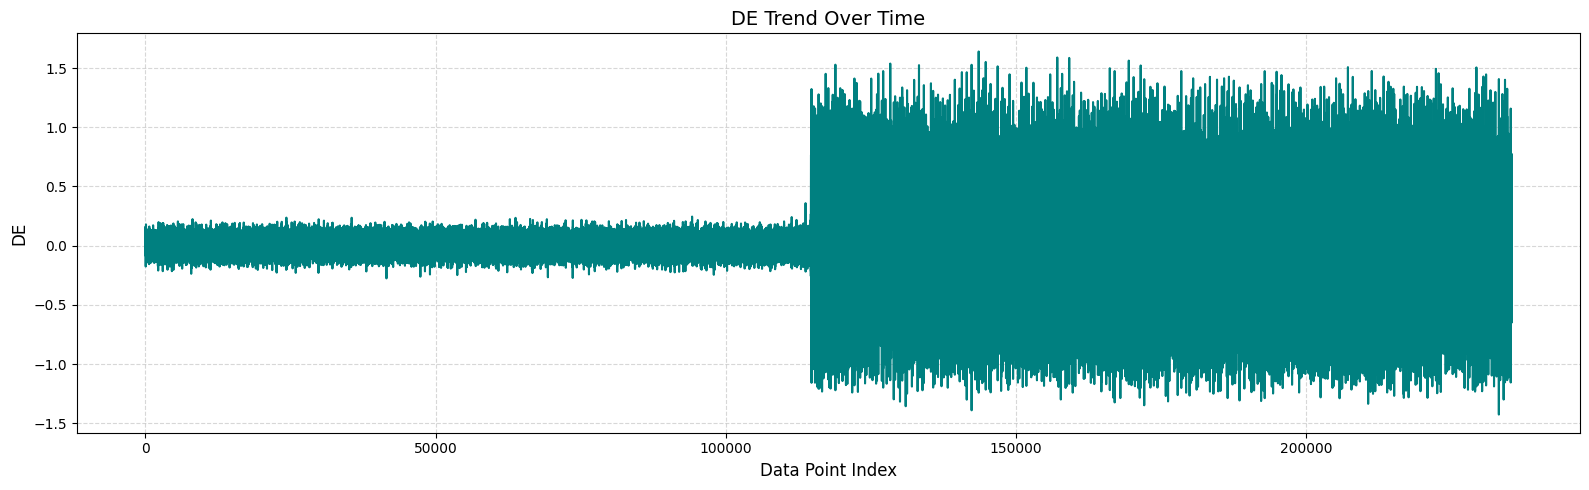

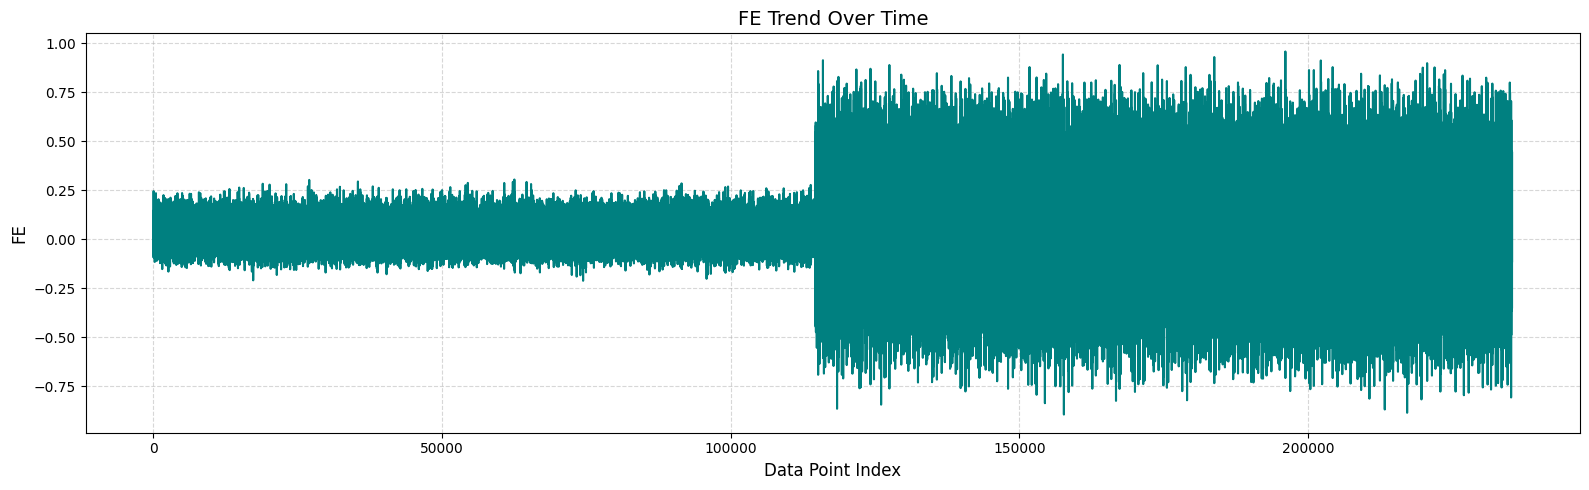

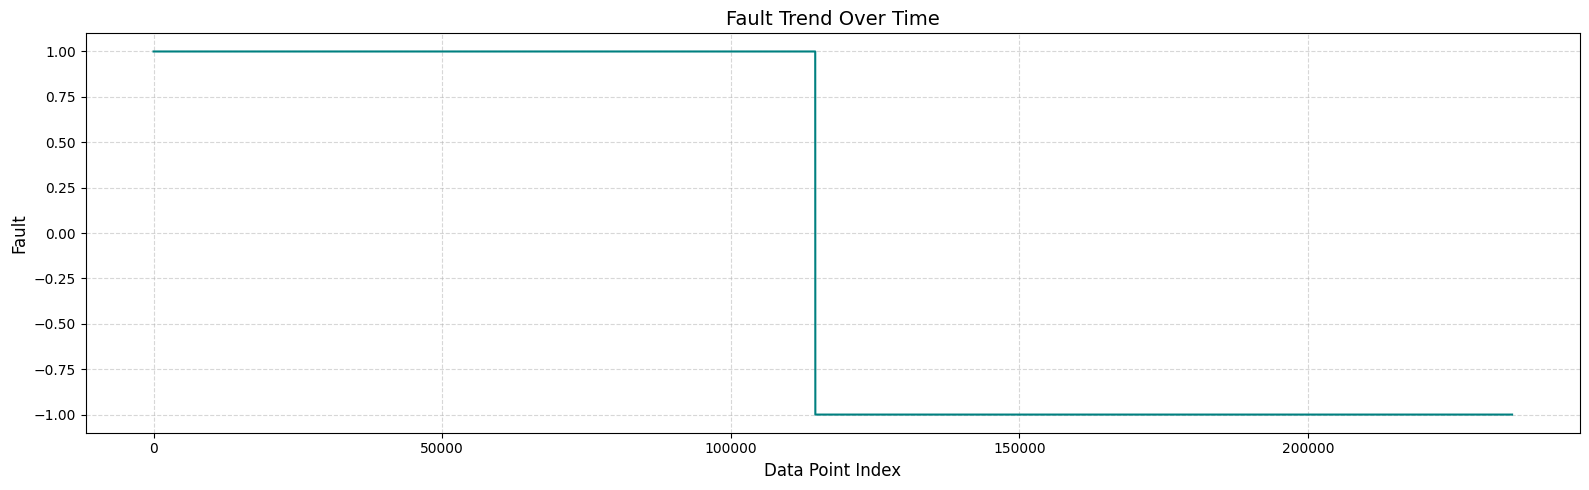

In [ ]:
for label, series in dataset.items():
    visualize_feature(series, label)

Heatmap

In [ ]:
dataset.corr() # corelation matrix

,DE,FE,Fault
DE,1.000000,0.088877,0.015778
FE,0.088877,1.000000,-0.002574
Fault,0.015778,-0.002574,1.000000


In [ ]:

dataset.corr().to_csv(r'Statistics/bearing-corr.csv', index = True)

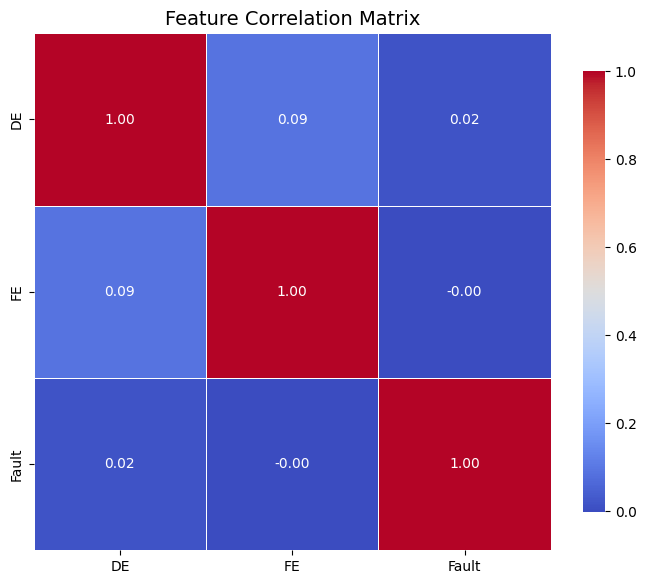

In [ ]:
# Generate and display correlation heatmap
fig, correlation_ax = plt.subplots(figsize=(7, 6))
cor_matrix = dataset.corr()

sns.heatmap(cor_matrix,
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            linecolor='white',
            square=True,
            cbar_kws={"shrink": .8},
            ax=correlation_ax)

correlation_ax.set_title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

Feature Engineering

In [ ]:
sc = StandardScaler()
X_inliers = sc.fit_transform(normal[['DE', 'FE']])
X = sc.transform(dataset[['DE', 'FE']])

In [ ]:
Y = dataset.iloc[:, 2]

In [ ]:
X

array([[ 0.82785884,  0.09052428],
       [ 0.80811591,  0.98237156],
       [-0.25471197,  1.45193072],
       ...,
       [ 5.98902043, -3.27832642],
       [ 2.74029281,  1.58428968],
       [-8.11271204, -2.23836316]])

In [ ]:
Y

,Fault
0,1
1,1
2,1
3,1
4,1
...,...
235364,-1
235365,-1
235366,-1
235367,-1


In [ ]:
X_inliers

array([[ 0.82785884,  0.09052428],
       [ 0.80811591,  0.98237156],
       [-0.25471197,  1.45193072],
       ...,
       [-0.62653722, -1.0376783 ],
       [-0.34355516, -1.2078541 ],
       [-0.36658859, -0.08280293]])

In [ ]:
# Save processed datasets using pickle for reuse
from pickle import dump
import os

# Create the directory as it doesn't exist
directory = "saved_data/bearing_anomaly"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save full feature set and labels
dump(X, open(os.path.join(directory, "X_features.pkl"), "wb"))
dump(Y, open(os.path.join(directory, "Y_labels.pkl"), "wb"))

# Save only the inliers subset (used for training in novelty detection)
dump(X_inliers, open(os.path.join(directory, "X_inliers_only.pkl"), "wb"))

In [ ]:
# train test split
X_train, X_test = train_test_split(normal, test_size = 0.2, shuffle=False, random_state = 0)
y_train, y_test = train_test_split(abnormal, test_size = 0.2, shuffle=False, random_state = 0)

# Feature scaling

train = pd.concat([X_train, y_train])
train = train.reset_index(drop=True)
train

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
...,...,...,...
193843,0.138557,-0.357080,-1
193844,0.210678,-0.204016,-1
193845,0.126537,-0.303867,-1
193846,-0.186476,-0.246956,-1


In [ ]:
test = pd.concat([X_test, y_test])
test = test.reset_index(drop=True)
test

,DE,FE,Fault
0,0.058204,-0.015204,1
1,0.011057,0.005958,1
2,-0.066548,0.066362,1
3,-0.131845,0.110535,1
4,-0.132471,0.096153,1
...,...,...,...
48457,0.135958,-0.047255,-1
48458,-0.083167,-0.070882,-1
48459,0.391469,-0.181005,-1
48460,0.185501,0.136011,-1


In [ ]:
# Save raw training and testing sets
import os

# Create the directory if it doesn't exist
directory = "pickle/dataset/bearing-anomaly-detection"
if not os.path.exists(directory):
    os.makedirs(directory)

dump(train, open(os.path.join(directory, "training_set.pkl"), "wb"))
dump(test, open(os.path.join(directory, "testing_set.pkl"), "wb"))

# Feature scaling
scaler = StandardScaler()
training_scaled = scaler.fit_transform(train[['DE', 'FE']])
testing_scaled = scaler.transform(test[['DE', 'FE']])

# Save scaled data
dump(training_scaled, open(os.path.join(directory, "training_scaled.pkl"), "wb"))
dump(testing_scaled, open(os.path.join(directory, "testing_scaled.pkl"), "wb"))

**Novelty Detection Overview**

In novelty detection, we:

1.Train only on normal (inlier) data

2.Test on a mix of normal and abnormal (outlier) data

3.This setup is suitable when anomalies are not available during training and we expect the model to generalize to unseen "abnormal" data.

In [ ]:
from pickle import load

# Load full feature dataset (with anomalies)
features_all = load(open('saved_data/bearing_anomaly/X_features.pkl', 'rb'))

# Load only the inlier (normal) samples
features_normal = load(open('saved_data/bearing_anomaly/X_inliers_only.pkl', 'rb'))

# Load corresponding labels (0 = normal, 1 = anomaly)
labels_all = load(open('saved_data/bearing_anomaly/Y_labels.pkl', 'rb'))

In [ ]:
# Initialize LOF model for novelty detection
lof_model = LocalOutlierFactor(n_neighbors=50, novelty=True)

# Train the model on normal (inlier) data only
lof_model.fit(features_normal)

# Predict anomalies on the complete dataset
predictions = lof_model.predict(features_all)
dataset['pred_anomalies'] = lof_model.predict(X)

In [ ]:
dataset

,DE,FE,Fault,pred_anomalies
0,0.064254,0.038625,1,1
1,0.063002,0.096769,1,1
2,-0.004381,0.127382,1,1
3,-0.035882,0.144640,1,1
4,-0.023991,0.086702,1,1
...,...,...,...,...
235364,0.135958,-0.047255,-1,1
235365,-0.083167,-0.070882,-1,1
235366,0.391469,-0.181005,-1,-1
235367,0.185501,0.136011,-1,1


In [ ]:
print_scores(Y, dataset['pred_anomalies'], lof_model)

Accuracy score: 79.7246%, Precision: 70.6362%, Recall: 99.8997%, F1 score: 82.7572%  LocalOutlierFactor(n_neighbors=50, novelty=True)


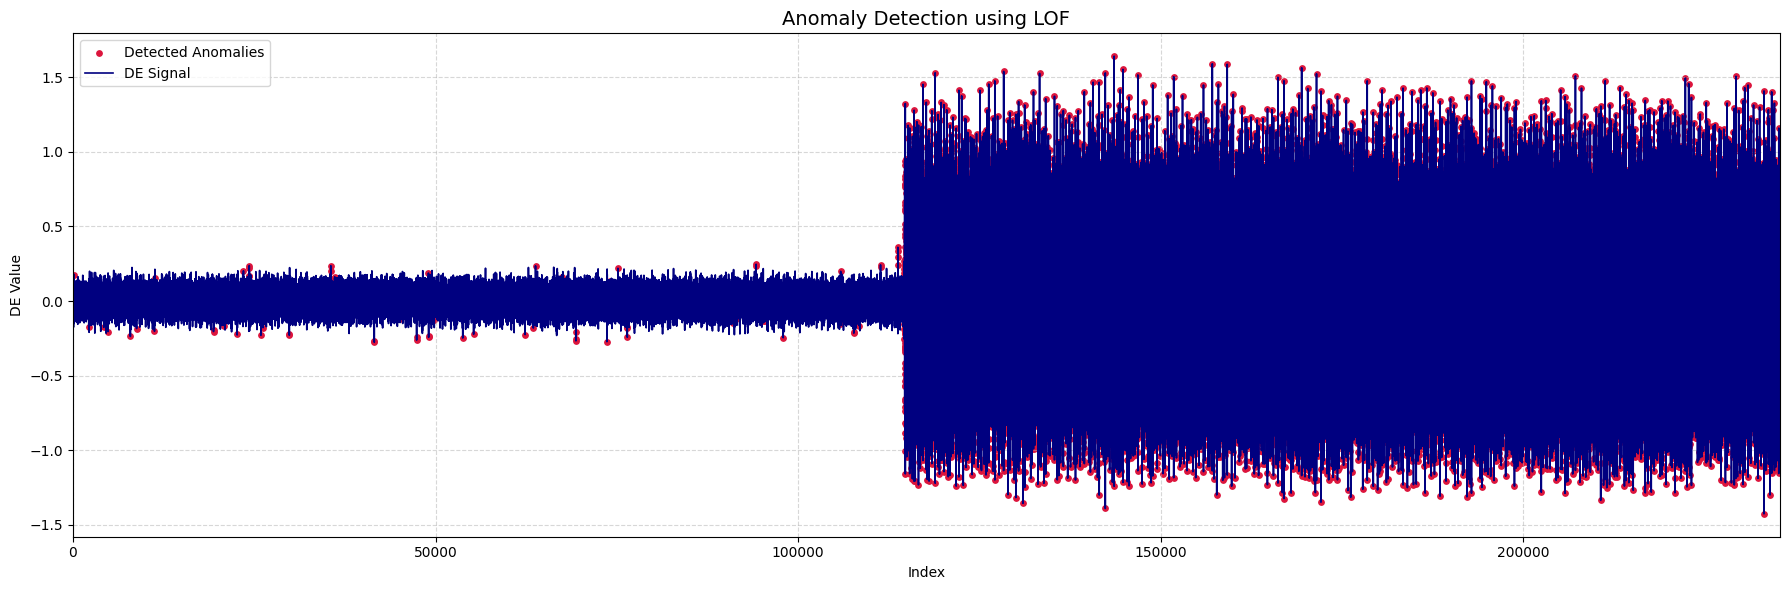

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))

# Filter the dataset to get the rows where anomalies were predicted
predicted_anomalies_data = dataset[dataset['pred_anomalies'] == -1]

# Plotting predicted anomalies
ax.scatter(predicted_anomalies_data.index, predicted_anomalies_data.DE, label='Detected Anomalies', color='crimson', s=15)

# Plotting original DE signal
ax.plot(dataset.index, dataset.DE, label='DE Signal', color='navy', linewidth=1.2)

# Axis settings
ax.set_xlim([0, len(dataset)])
ax.set_title('Anomaly Detection using LOF', fontsize=14)
ax.set_xlabel('Index')
ax.set_ylabel('DE Value')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Anomaly Identification

Elliptic Envelope

In [ ]:
# Load preprocessed datasets
train_set = load(open('pickle/dataset/bearing-anomaly-detection/training_set.pkl', 'rb'))
test_set = load(open('pickle/dataset/bearing-anomaly-detection/testing_set.pkl', 'rb'))
train_scaled = load(open('pickle/dataset/bearing-anomaly-detection/training_scaled.pkl', 'rb'))
test_scaled = load(open('pickle/dataset/bearing-anomaly-detection/testing_scaled.pkl', 'rb'))

# Apply Elliptic Envelope for anomaly detection
from sklearn.covariance import EllipticEnvelope
elliptic_detector = EllipticEnvelope(random_state=42)
train_set['is_outlier'] = elliptic_detector.fit_predict(train_scaled)

# Filter detected outliers
outlier_points = train_set[train_set['is_outlier'] == -1]


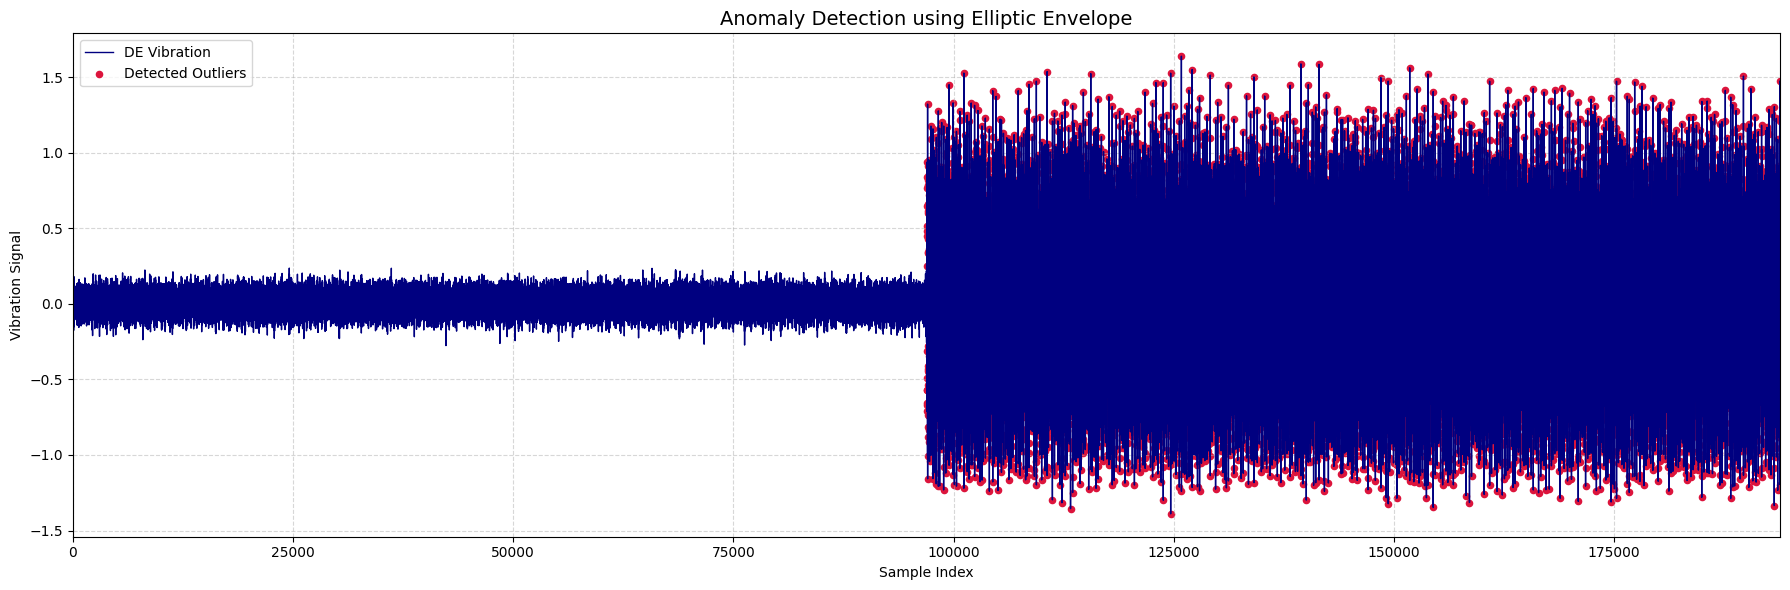

In [ ]:

# Plotting results
plt.figure(figsize=(18, 6))
plt.plot(train_set.index, train_set.DE, label='DE Vibration', color='navy', linewidth=1)
plt.scatter(outlier_points.index, outlier_points.DE, label='Detected Outliers', color='crimson', s=20)
plt.title('Anomaly Detection using Elliptic Envelope', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Vibration Signal')
plt.xlim([0, len(train_set.index)])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

isolation detection Analysis

In [ ]:
# load data
training_set = load(open('pickle/dataset/bearing-anomaly-detection/training_set.pkl', 'rb'))
testing_set = load(open('pickle/dataset/bearing-anomaly-detection/testing_set.pkl', 'rb'))
training_scaled = load(open('pickle/dataset/bearing-anomaly-detection/training_scaled.pkl', 'rb'))
testing_scaled = load(open('pickle/dataset/bearing-anomaly-detection/testing_scaled.pkl', 'rb'))

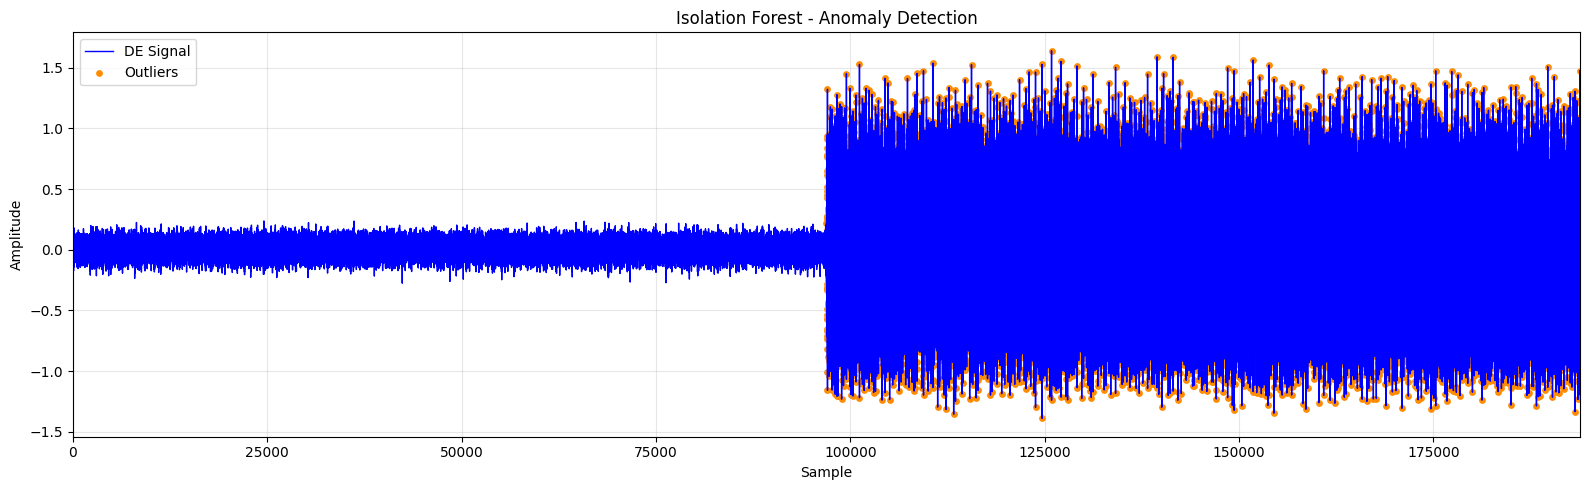

In [ ]:
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(train_scaled)
train_set['outlier_flag'] = iso_forest.predict(train_scaled)

# Extract detected anomalies
isolated_points = train_set[train_set['outlier_flag'] == -1]

# Plot detected anomalies over DE signal
plt.figure(figsize=(16, 5))
plt.plot(train_set.index, train_set.DE, label='DE Signal', color='blue', linewidth=1)
plt.scatter(isolated_points.index, isolated_points.DE, color='darkorange', label='Outliers', s=15)
plt.title('Isolation Forest - Anomaly Detection')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xlim([0, len(train_set)])
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Accuracy Score of above anomaly detection

In [ ]:
print_scores(train_set['Fault'], train_set['outlier_flag'], iso_forest)

Accuracy score: 67.8325%, Precision: 60.8513%, Recall: 100.0000%, F1 score: 75.6616%  IsolationForest(random_state=42)


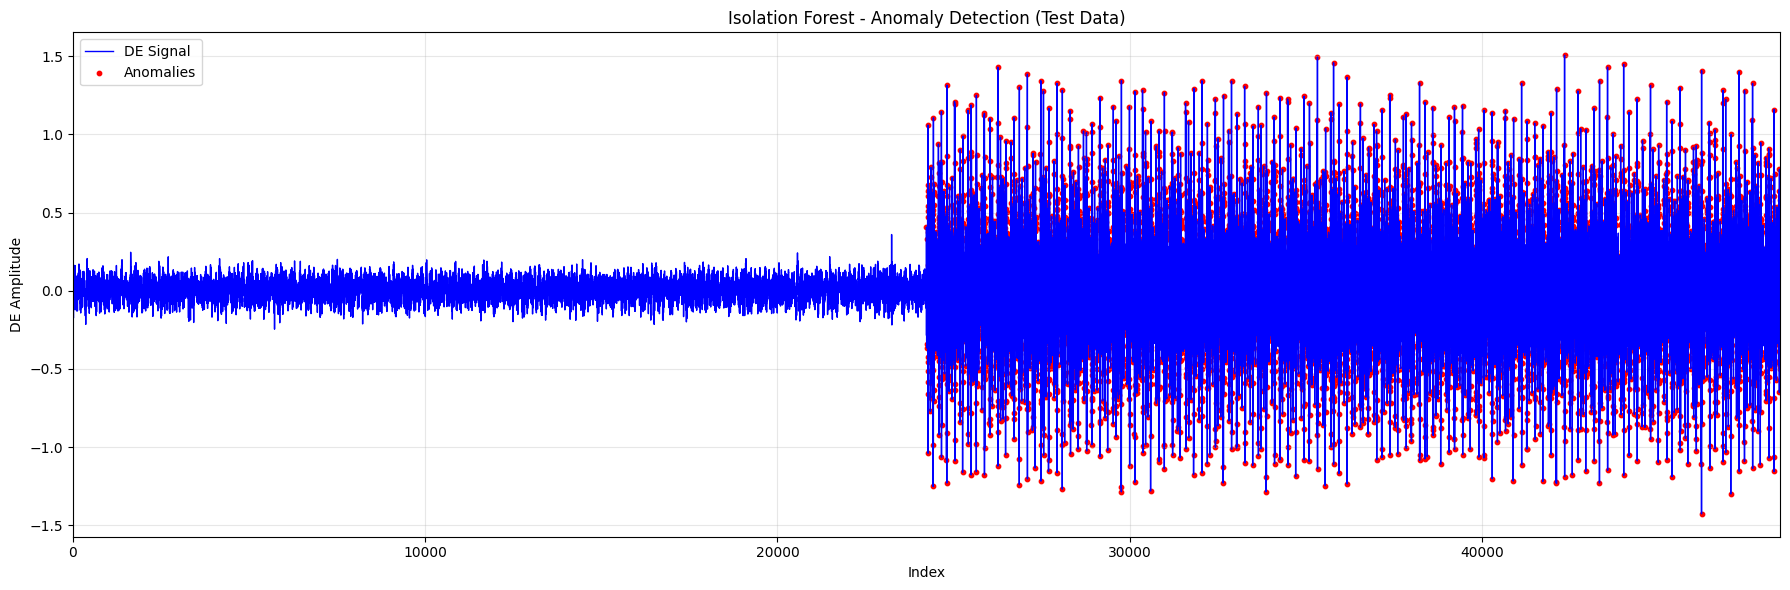

In [ ]:
test['pred_anomaly'] = iso_forest.predict(testing_scaled)

# Predict anomalies on test data
test['pred_anomaly'] = iso_forest.predict(testing_scaled)

# Extract anomalies
test_anomalies = test[test['pred_anomaly'] == -1]

# Visualization
plt.figure(figsize=(18, 6))
plt.plot(test.index, test.DE, label='DE Signal', color='blue', linewidth=1)
plt.scatter(test_anomalies.index, test_anomalies.DE, label='Anomalies', color='red', s=10)
plt.xlim([0, len(test.index)])
plt.title('Isolation Forest - Anomaly Detection (Test Data)')
plt.xlabel('Index')
plt.ylabel('DE Amplitude')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

One class SVM

In [ ]:
# load data
train = load(open('pickle/dataset/bearing-anomaly-detection/training_set.pkl', 'rb'))
test = load(open('pickle/dataset/bearing-anomaly-detection/testing_set.pkl', 'rb'))
train_data = load(open('pickle/dataset/bearing-anomaly-detection/training_scaled.pkl', 'rb'))
test_data = load(open('pickle/dataset/bearing-anomaly-detection/testing_scaled.pkl', 'rb'))

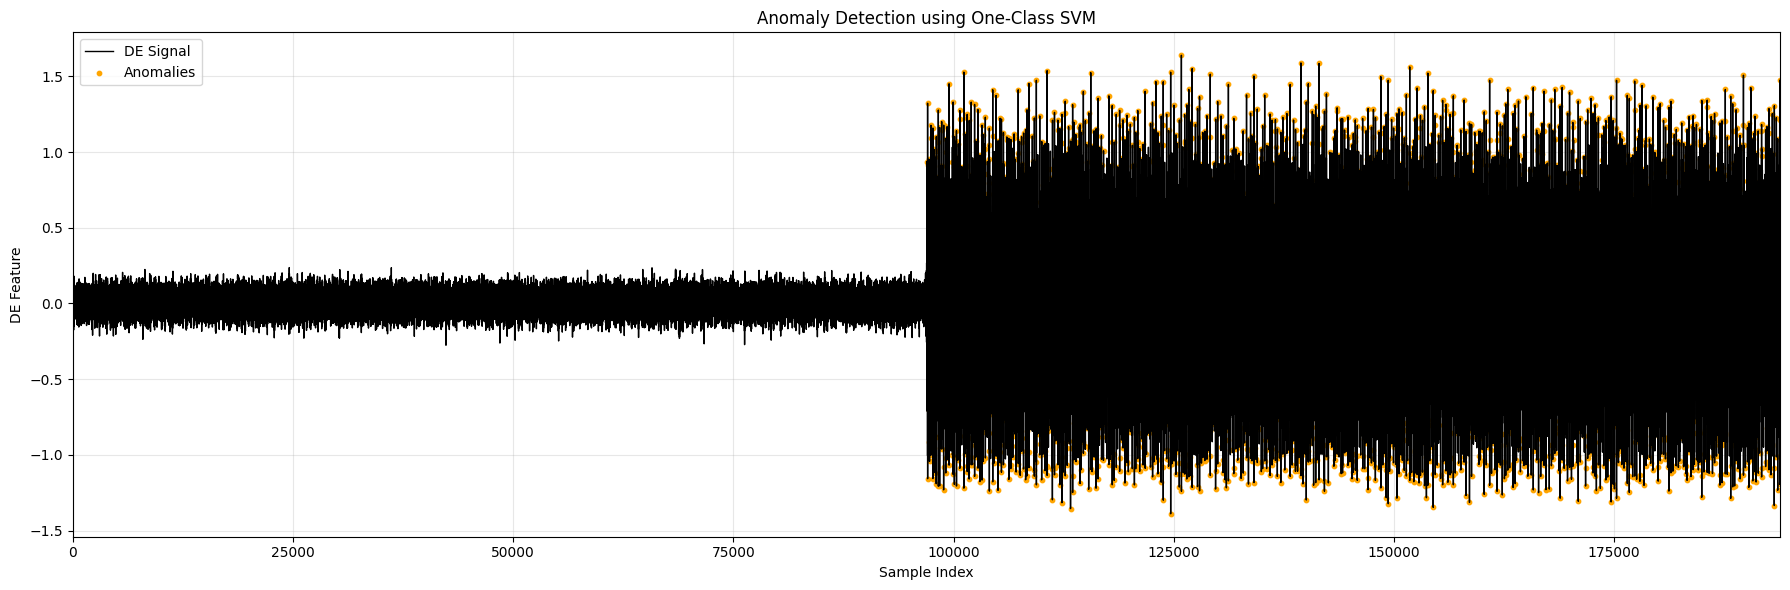

In [ ]:
# Train One-Class SVM
svm_model = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
svm_model.fit(train_data)

# Predict anomalies
train['anomaly_flag'] = svm_model.predict(train_data)
anomalies_detected = train[train['anomaly_flag'] == -1]

# Visualization
plt.figure(figsize=(18, 6))
plt.plot(train.index, train.DE, label='DE Signal', color='black', linewidth=1)
plt.scatter(anomalies_detected.index, anomalies_detected.DE, color='orange', s=10, label='Anomalies')
plt.title('Anomaly Detection using One-Class SVM')
plt.xlabel('Sample Index')
plt.ylabel('DE Feature')
plt.legend()
plt.grid(alpha=0.3)
plt.xlim([0, len(train.index)])
plt.tight_layout()
plt.show()


accuracy on training score

In [ ]:
print_scores(train['Fault'], train['anomaly_flag'], svm_model)

Accuracy score: 50.9992%, Precision: 50.5047%, Recall: 100.0000%, F1 score: 67.1138%  OneClassSVM(gamma=0.01, nu=0.01)


Prediction on testing data

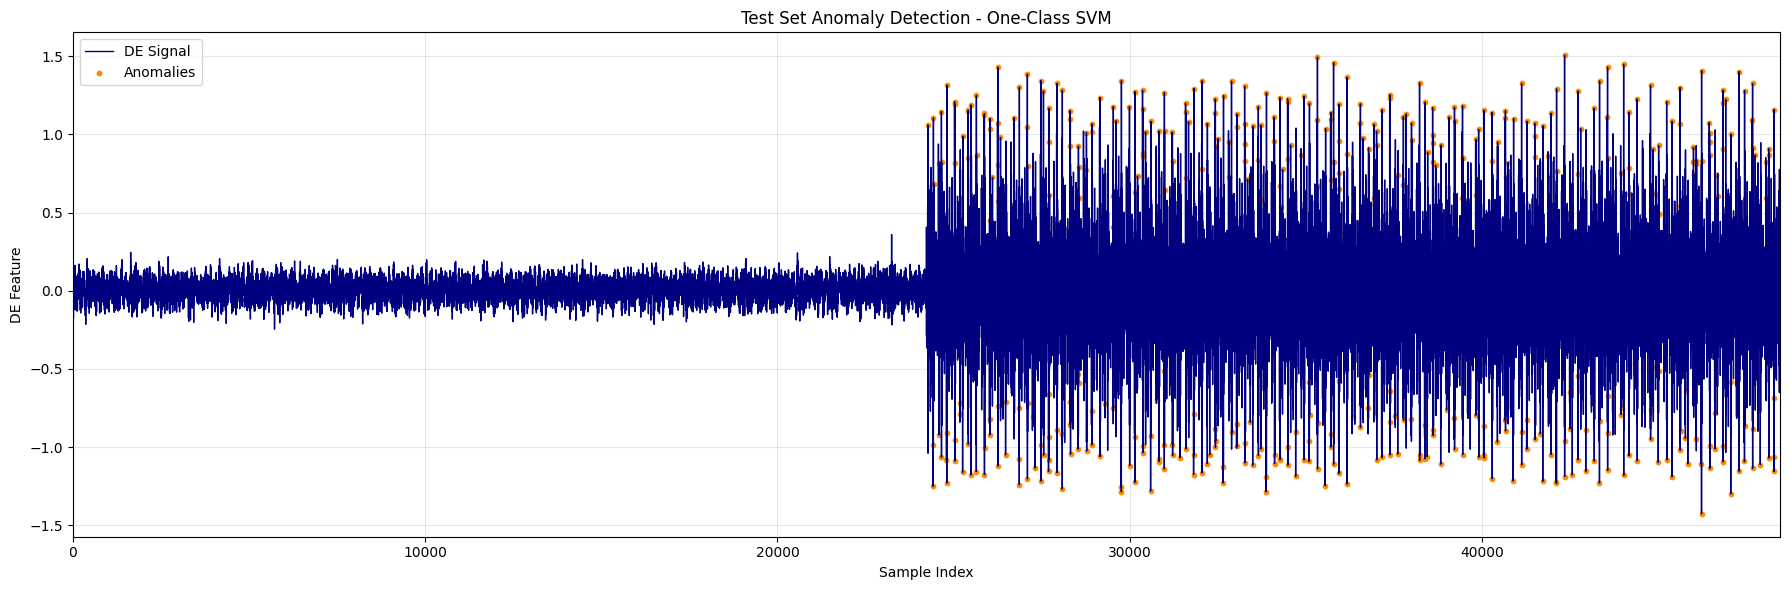

In [ ]:
# Predict anomalies in the test set
test['anomaly_flag'] = svm_model.predict(test_data)
anomaly_points = test[test['anomaly_flag'] == -1]

# Plotting results
plt.figure(figsize=(18, 6))
plt.plot(test.index, test.DE, label='DE Signal', color='navy', linewidth=1)
plt.scatter(anomaly_points.index, anomaly_points.DE, color='darkorange', s=10, label='Anomalies')

plt.title('Test Set Anomaly Detection - One-Class SVM')
plt.xlabel('Sample Index')
plt.ylabel('DE Feature')
plt.legend()
plt.grid(alpha=0.3)
plt.xlim([0, len(test.index)])
plt.tight_layout()
plt.show()

In [ ]:
print_scores(test['Fault'], test['anomaly_flag'], svm_model)

Accuracy score: 51.0173%, Precision: 50.5139%, Recall: 100.0000%, F1 score: 67.1219%  OneClassSVM(gamma=0.01, nu=0.01)
